<a href="https://colab.research.google.com/github/adityamkk/neuroapoptosis/blob/main/NeuroapoptosisModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuroapoptosis Model with a CNN Classifier - Bodies vs. Nonbodies

## Dependencies

In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.1 MB/s eta 0:00:00


For accessing files and filepaths within the drive

In [ ]:
import os;
from pathlib import Path;

Data Manipulation and Plotting

In [ ]:
import numpy as np;
import pandas as pd;
import math;
import matplotlib.pyplot as plt;

Miscellaneous

In [ ]:
import re;
import random;
import copy;

Tensorflow and Keras

In [ ]:
# %tensorflow_version 2.x
#https://github.com/sudhir2016/Google-Colab-3/blob/master/VGG16.ipynb

import tensorflow as tf;
from tensorflow import keras;
from keras import layers, models;
import keras_tuner as kt;

Keras Imports

In [ ]:
from keras.models import Model;
from keras.optimizers import Adam;
from keras import regularizers;
from keras.layers import Activation;
from keras.callbacks import ModelCheckpoint, EarlyStopping;
from keras.layers import Dense, Dropout, Flatten;
from keras.preprocessing.image import ImageDataGenerator;
from keras.applications.vgg16 import preprocess_input;
from keras.applications.vgg16 import decode_predictions;
from keras.applications.vgg16 import VGG16;
from keras.utils import to_categorical;

SKlearn for the PCA and SVM

In [ ]:
from sklearn.svm import LinearSVC;
from sklearn.pipeline import make_pipeline;
from sklearn.preprocessing import StandardScaler;
from sklearn.datasets import make_classification;
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Google Drive and Google Spreadsheets

In [ ]:
from google.colab import drive;
drive.mount('/content/drive');
print(tf.__version__);
print(keras.__version__);

from google.colab import auth;
auth.authenticate_user();

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

Mounted at /content/drive
2.12.0
2.12.0


## Data

Bodies and Non-bodies images

In [ ]:
# Bodies images
bodies_ds = [];
bodies = [];
# Non-bodies images
nonbodies_ds = [];
nonbodies = [];

Get images from folder

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/BodyClassifier/Stimuli/';

Separate the files into Bodies or Non-bodies

In [ ]:
for filename in os.listdir(path) :
  f = os.path.join(path, filename);
  # Human or monkey bodies
  regex = re.compile('(humbod)|(monbod)');
  # 224 x 224 images
  image = keras.preprocessing.image.load_img(f, target_size=(224,224));
  image = tf.keras.preprocessing.image.img_to_array(image);
  if(regex.match(filename)):
    # Bodies are either human bodies or monkey bodies...
    bodies_ds.append(image);
    bodies.append(image);
  else:
    # And everything else is a non-body
    nonbodies_ds.append(image);
    nonbodies.append(image);

Create the Train and Test data and labels

In [ ]:
# Training Data
train_ds = [];
validation_ds = [];
# Training Labels
train_labels = [];
validation_labels = [];
# Testing Data
test_ds = [];
# Testing Labels
test_labels = [];

In [ ]:
print("Bodies: " + str(len(bodies_ds)));
print("non-Bodies: " + str(len(nonbodies_ds)));

Bodies: 20
non-Bodies: 89


Designate *10*% of the data to be test data (5 from each set) and *3* from each set to be validation data for training

In [ ]:
for i in range(5):
  test_ds.append(bodies_ds.pop(random.randint(0,len(bodies_ds)-1)));
  test_labels.append(1);
for i in range(4):
  validation_ds.append(bodies_ds.pop(random.randint(0,len(bodies_ds)-1)));
  validation_labels.append(1);

for i in range(5):
  test_ds.append(nonbodies_ds.pop(random.randint(0,len(nonbodies_ds)-1)));
  test_labels.append(0);
for i in range(4):
  validation_ds.append(nonbodies_ds.pop(random.randint(0,len(nonbodies_ds)-1)));
  validation_labels.append(0);

...and the remaining *90*% to be train data

In [ ]:
for img in bodies_ds:
  train_ds.append(img);
  train_labels.append(1);
for img in nonbodies_ds:
  train_ds.append(img);
  train_labels.append(0);

Format the training and testing images to 224x224 pixel images

In [ ]:
# Resize images to be 224 x 224
train_ds = tf.image.resize(train_ds, (224,224));
validation_ds = tf.image.resize(validation_ds, (224,224));
test_ds = tf.image.resize(test_ds, (224,224));

Convert the training dataset from a regular array to a numpy array

In [ ]:
# Convert the train_labels into a numpy array for training the model
train_labels = np.asarray(train_labels);
validation_labels = np.asarray(validation_labels)
test_labels = np.asarray(test_labels);

Preprocess the data according to tensorflow specifications

In [ ]:
# Preprocess the input data for the model
train_ds = preprocess_input(train_ds);
validation_ds = preprocess_input(validation_ds);
test_ds = preprocess_input(test_ds);

## Model Construction and Training

Initiate a new VGG16 model

In [ ]:
# Obtain VGG16 weights from imagenet, and set the input shape to the shape of the image
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape);
# Make sure the VGG16 model is not trainable
base_model.trainable = False;

58889256/58889256 [==============================] - 2s 0us/step


Instantiate a new Flatten Layer

In [ ]:
# Flatten Layer
flatten_layer = layers.Flatten();

Pass images through base model and the flatten layer to obtain 1D representations of outputs of VGG16

In [ ]:
train_pca_ds_init = [];
for image in train_ds:
  # Reshape the input tensor to match the requirements of the VGG16 model
  input_tensor = tf.reshape(image, (1, 224, 224, 3));
  # Get the output of the VGG16 model
  base_output = base_model.call(input_tensor);
  # flatten the output into 1D space
  flatten_output = flatten_layer.call(base_output);
  train_pca_ds_init.append(tf.reshape(flatten_output, (tf.shape(flatten_output)[1])))

In [ ]:
validation_pca_ds_init = [];
for image in validation_ds:
  # Reshape the input tensor to match the requirements of the VGG16 model
  input_tensor = tf.reshape(image, (1, 224, 224, 3));
  # Get the output of the VGG16 model
  base_output = base_model.call(input_tensor);
  # flatten the output into 1D space
  flatten_output = flatten_layer.call(base_output);
  validation_pca_ds_init.append(tf.reshape(flatten_output, (tf.shape(flatten_output)[1])))

In [ ]:
eigenvalues = PCA(svd_solver="randomized").fit(train_pca_ds_init).explained_variance_
total_variance = 0.
for e in eigenvalues:
  total_variance += e

category_variance = 0.
variance = 0.
num_categories = 1
for e in eigenvalues:
  if(variance >= 0.95):
    break;
  category_variance += e
  variance = category_variance/total_variance
  num_categories += 1
print("The optimal number of categories to perform PCA with is " + str(num_categories))

The optimal number of categories to perform PCA with is 62


Perform PCA to obtain the most important dimensions to obtain transformed data

In [ ]:
pca = PCA(n_components=num_categories, svd_solver="randomized").fit(train_pca_ds_init)
train_pca_ds = pca.transform(train_pca_ds_init)
validation_pca_ds = pca.transform(validation_pca_ds_init)

Create function to build SVM with hyperparameter optimization for ridge regression

In [ ]:
def model_builder(hp):

  #https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/#:~:text=The%20most%20common%20type%20of,range%20between%200%20and%200.1.
  hp_l2_lambda = hp.Float(name='l2_lambda', min_value=0.0, max_value=0.1)
  svm = Dense(1, kernel_regularizer=regularizers.l2(hp_l2_lambda), activation='linear');

  model = models.Sequential([
      svm
  ]);

  #hp_learning_rate = hp.Choice(name='learning_rate', values=[1e-2, 1e-3, 1e-4]);

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='hinge',
    metrics=['accuracy'],
  )

  return model;

Model tuner with Hyperband

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     directory='my_dir',
                     project_name='neuroapoptosis_kt')

In [ ]:
es_hyper= EarlyStopping(monitor='val_accuracy', patience=5)

Train the hypermodel under the same conditions for the regular model

In [ ]:
tuner.search(train_pca_ds, train_labels, validation_data=(validation_pca_ds, validation_labels), batch_size=20, epochs=50, callbacks=[es_hyper])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print('The optimized value for the l2 lambda hyperparamter is ' + str(best_hps.get('l2_lambda')))
#print('The optimized value for the learning rate hyperparamter is ' + str(best_hps.get('learning_rate')))

The optimized value for the l2 lambda hyperparamter is 0.09783548583709967


Construct the linear classifier and train it under the optimal hyperparameter

In [ ]:
test_pca_ds_init = [];
for image in test_ds:
  # Reshape the input tensor to match the requirements of the VGG16 model
  input_tensor = tf.reshape(image, (1, 224, 224, 3));
  # Get the output of the VGG16 model
  base_output = base_model.call(input_tensor);
  # flatten the output into 1D space
  flatten_output = flatten_layer.call(base_output);
  test_pca_ds_init.append(tf.reshape(flatten_output, (tf.shape(flatten_output)[1])))
test_pca_ds = pca.transform(test_pca_ds_init)

In [ ]:
linear_classifier = tuner.hypermodel.build(best_hps)

es = EarlyStopping(monitor='val_accuracy', patience=10,  restore_best_weights=True)

linear_classifier.fit(train_pca_ds, train_labels, validation_data=(validation_pca_ds, validation_labels), batch_size=20, epochs=50, callbacks=[es]);

Epoch 1/50
5/5 [==============================] - 1s 59ms/step - loss: 43.8977 - accuracy: 0.4835 - val_loss: 20.8367 - val_accuracy: 0.3750
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 35.1611 - accuracy: 0.5714 - val_loss: 13.3268 - val_accuracy: 0.6250
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 29.2708 - accuracy: 0.6154 - val_loss: 9.2136 - val_accuracy: 0.6250
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 24.0809 - accuracy: 0.6264 - val_loss: 6.4280 - val_accuracy: 0.7500
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 19.2397 - accuracy: 0.7033 - val_loss: 4.7669 - val_accuracy: 0.7500
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 15.4530 - accuracy: 0.7692 - val_loss: 2.8360 - val_accuracy: 0.7500
Epoch 7/50
5/5 [==============================] - 0s 20ms/step - loss: 12.6011 - accuracy: 0.7802 - val_loss: 1.1916 - val_accuracy: 0.7500
Epoch 8/50
5/5 [==

In [ ]:
score = linear_classifier.evaluate(test_pca_ds, test_labels)

1/1 [==============================] - 0s 34ms/step - loss: 0.1943 - accuracy: 1.0000


## Calculate layer BSIs

*See* what layers are within the VGG16 model

In [ ]:
list(map(lambda x: x.name, base_model.layers))

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

Get the number of neurons in the target layer

In [ ]:
num_neurons = 1;
layer_shape = base_model.get_layer('block5_conv3').output_shape;
for i in range(len(layer_shape)):
  if i != 0:
    num_neurons *= layer_shape[i];
print(num_neurons);

100352


Find the Mean Body Firing Rate for each neuron in the target layer

In [ ]:
# Resizing the images
bodies = tf.image.resize(bodies, (224,224));
# bodies = preprocess_input(bodies);

# Create array to store information on the mean firing rates of each neuron in the layer
bodies_activations = np.zeros(num_neurons);

# Loop through all body stimuli
for i in range(len(bodies)):
  # Find activations of last vgg16 layer
  intermediate_output = tf.keras.Model(base_model.get_layer('input_1').input, base_model.get_layer('block5_conv3').output);
  extracted = intermediate_output(bodies[i][None, ...]);
  # Reshape the activations into 1D numpy array
  extracted = tf.reshape(extracted, (num_neurons)).numpy();
  # Add activations together
  bodies_activations = bodies_activations + extracted;

# Divide by total number of stimuli to get the average activations
bodies_activations = bodies_activations / len(bodies);
print(bodies_activations);

[0. 0. 0. ... 0. 0. 0.]


Find the Mean Nonbody Firing Rate for each neuron in the target layer

In [ ]:
# Resizing the images
nonbodies = tf.image.resize(nonbodies, (224,224));
# nonbodies = preprocess_input(nonbodies);

# Create array to store information on the mean firing rates of each neuron in the layer
nonbodies_activations = np.zeros(num_neurons);

# Loop through all nonbody stimuli
for i in range(len(nonbodies)):
  # Find activations of last vgg16 layer
  intermediate_output = tf.keras.Model(base_model.get_layer('input_1').input, base_model.get_layer('block5_conv3').output);
  extracted = intermediate_output(nonbodies[i][None, ...]);
  # Reshape the activations into 1D numpy array
  extracted = tf.reshape(extracted, (num_neurons)).numpy();
  # Add activations together
  nonbodies_activations = nonbodies_activations + extracted;

# Divide by total number of stimuli to get the average activations
nonbodies_activations = nonbodies_activations / len(nonbodies);
print(nonbodies_activations);

[0. 0. 0. ... 0. 0. 0.]


Generate Grayscale Images for Baseline

In [ ]:
# Grayscale images
grayscale_images = [];
for gray in range(255):
  grayscale_images.append(gray * np.ones((224,224,3)));

Find the Baseline Firing Rate for each neuron in the target layer

In [ ]:
# Create array to store information on the baseline activations of each neuron in the layer
baseline_activations = np.zeros(num_neurons);

# Loop through all grayscale stimuli
for i in range(len(grayscale_images)):
  # Find activations of the last vgg16 layer
  intermediate_output = tf.keras.Model(base_model.get_layer('input_1').input, base_model.get_layer('block5_conv3').output);
  extracted = intermediate_output(grayscale_images[i][None, ...]);
  # Reshape the activations into 1D numpy array
  extracted = tf.reshape(extracted, (num_neurons)).numpy();
  # Add activations together
  baseline_activations = baseline_activations + extracted;

# Divide by total number of stimuli to get the average activations
baseline_activations = baseline_activations / len(grayscale_images);
print(baseline_activations);

[0.0002834  0.         0.         ... 0.         0.01370914 0.        ]


Find the Net Body and Nonbody Firing Rates in the target layer

In [ ]:
# Net Firing Rates
net_body_firing_rates = bodies_activations - baseline_activations;
net_nonbody_firing_rates = nonbodies_activations - baseline_activations;

Calculate the Body Selectivity Index (BSI) for each neuron in the target layer

In [ ]:
# BSIs
BSIs = (net_body_firing_rates - net_nonbody_firing_rates);
denom = (abs(net_body_firing_rates) + abs(net_nonbody_firing_rates));
for i in range(len(BSIs)):
  # Check for divisibility by zero
  if denom[i] != 0:
    BSIs[i] = BSIs[i]/denom[i];
  else:
    # Equally selective to both bodies and nonbodies
    BSIs[i] = 0
print(BSIs);

[0. 0. 0. ... 0. 0. 0.]


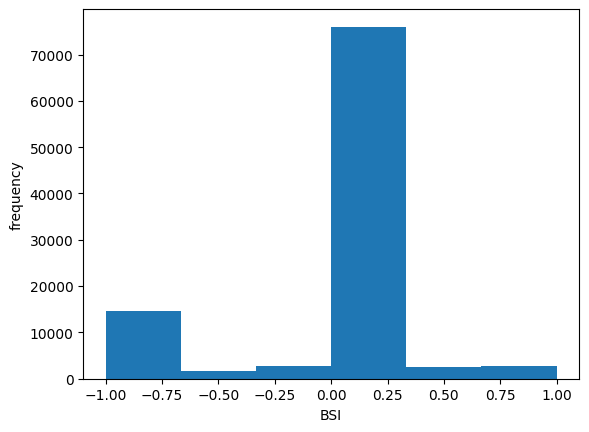

In [ ]:
plt.hist(BSIs, 6, range=(-1, 1));
plt.ylabel("frequency");
plt.xlabel("BSI");
plt.show();

## Deletion Procedure

Define removal rates

In [ ]:
removal_rates = np.arange(0, 1.1, 0.1);

Define threshold index and the total number of neurons in target layer above that threshold index

In [ ]:
BSI_threshold = 0.33;
total_num_above_BSI_threshold = 0;
for b in BSIs:
  if b >= BSI_threshold or b <= -1*BSI_threshold:
    total_num_above_BSI_threshold += 1;

print("There are " + str(total_num_above_BSI_threshold) + " neurons, or a proportion of " + str(total_num_above_BSI_threshold/num_neurons) + " above the BSI threshold of " + str(BSI_threshold));

There are 21667 neurons, or a proportion of 0.2159099968112245 above the BSI threshold of 0.33


Get Data from deletions

In [ ]:
# Function for cloning and cutting model at a particular layer
def cut_model(model, cut_layer_name):
    clone = keras.models.clone_model(model)
    clone.set_weights(model.get_weights())
    cut_layer = clone.get_layer(name=cut_layer_name) #.get_layer(name='vgg16')
    model_a = Model(clone.inputs, cut_layer.output)
    model_b = Model(
        keras.Input(tensor=cut_layer.output), clone.outputs
    )
    return model_a, model_b

In [ ]:
# Store data for each removal rate
data = [];

# Cut the base model by the target layer
intervention, termination = cut_model(base_model, 'block5_conv3');

# Loop through each removal rate
for rr in removal_rates:
  removal_data = np.zeros((100,2));
  # Loop through each trial
  for trial in range(100): #100 trials

    # Count the number of correct predictions made by the model
    correct_pred = 0;

    # Choose indices to delete
    deletion_indices = np.random.choice(num_neurons, int(rr*num_neurons), replace=False);
    # Count the number of deleted activations above the BSI threshold
    count_act_above_threshold = 0;
    for d_idx in deletion_indices:
        # Add to counter if the BSI of the about-to-be-deleted neuron is above the threshold
        if BSIs[d_idx] >= BSI_threshold or BSIs[d_idx] <= -1*BSI_threshold:
          count_act_above_threshold += 1;

    # Loop through testing dataset
    for stim_idx in range(len(test_ds)):

      # Feed stimulus through until the target layer
      extracted = intervention(test_ds[stim_idx][None, ...]);
      # Record the original shape of the activations
      original_shape = tuple(tf.shape(extracted).numpy());
      # Convert activations to 1D numpy array
      extracted = tf.reshape(extracted, (num_neurons)).numpy();

      # Delete all randomly selected neurons
      for d_idx in deletion_indices:
        # Delete the activation of the neuron
        extracted[d_idx] = 0;

      # Convert activations back to tensor format
      extracted = tf.convert_to_tensor(extracted);
      # Reshape the tensor back to the original format
      extracted = tf.reshape(extracted, original_shape);

      # Finish the feedforward pass through the vgg16 layer
      vgg_prediction = termination(extracted);

      # Flatten the prediction
      vgg_prediction = flatten_layer.call(vgg_prediction)

      # Apply PCA to the prediction
      vgg_prediction = pca.transform(vgg_prediction)

      # Make the prediction based on the output of the vgg16 model
      prediction = linear_classifier(vgg_prediction).numpy()[0];
      # Get the actual results
      actual = test_labels[stim_idx];

      # Check for a correct prediction
      #if (prediction[0] - prediction[1] > 0 and actual[0] == 1.) or (prediction[0] - prediction[1] < 0 and actual[1] == 1.):
      if (prediction[0] >= 0.5 and actual == 1.) or (prediction[0] < 0.5 and actual == 0.):
        # Increase correct answer counter by 1
        correct_pred += 1;

      #print("prediction: " + str(prediction) + " | actual: " + str(actual));

    # Calculate the thresholded_BSI_rate and accuracy of the model
    thresholded_BSI_rate = (total_num_above_BSI_threshold - count_act_above_threshold) / ((num_neurons - int(rr*num_neurons)) if num_neurons > int(rr*num_neurons) else 1);
    accuracy = correct_pred / (len(test_ds));

    #print("Removal Rate " + str(int(rr*100)) + "% | Trial #" + str(trial + 1) + " | thresholded_BSI_rate = " + str(thresholded_BSI_rate) + " , accuracy = " + str(accuracy));

    # Add data to removal_data
    removal_data[trial][0] = thresholded_BSI_rate;
    removal_data[trial][1] = accuracy;
  # Append data from removal rate
  data.append(removal_data);
  print("Removal Rate for " + str(int(rr*100)) + "% Complete");

Removal Rate for 0% Complete
Removal Rate for 10% Complete
Removal Rate for 20% Complete
Removal Rate for 30% Complete
Removal Rate for 40% Complete
Removal Rate for 50% Complete
Removal Rate for 60% Complete
Removal Rate for 70% Complete
Removal Rate for 80% Complete
Removal Rate for 90% Complete
Removal Rate for 100% Complete


## Analysis

Find the mean accuracies of the model

In [ ]:
removal_accuracies = []
for r_dat in data:
  avg_accuracy = 0;
  for (t_BSI_r, acc) in r_dat:
    avg_accuracy += acc;
  avg_accuracy = avg_accuracy / len(r_dat);
  removal_accuracies.append(avg_accuracy);

Plot the mean accuracies against the removal rates

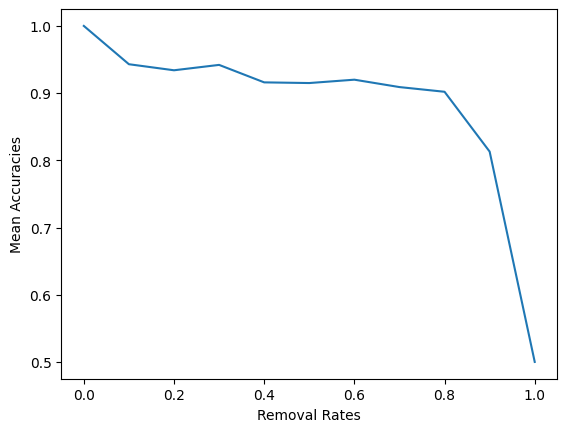

In [ ]:
plt.plot(removal_rates, removal_accuracies);
plt.xlabel("Removal Rates");
plt.ylabel("Mean Accuracies");
plt.show();

Store data in google sheet

In [ ]:
sheet_name = 'neuroapoptosis_pca_data_10_date_8_14_2023';

sh = gc.create(sheet_name);

# Open our new sheet and add some data.
worksheet = gc.open(sheet_name).sheet1

worksheet.add_rows(10000);

row = 2;
for r_idx in range(len(data)):
  cell_list = worksheet.range('A' + str(row) + ':A' + str(row + len(data[r_idx])));
  for cell_idx in range(len(data[r_idx])):
    cell_list[cell_idx].value = data[r_idx][cell_idx][0];
  worksheet.update_cells(cell_list);
  cell_list = worksheet.range('B' + str(row) + ':B' + str(row + len(data[r_idx])));
  for cell_idx in range(len(data[r_idx])):
    cell_list[cell_idx].value = data[r_idx][cell_idx][1];
  worksheet.update_cells(cell_list);

  row += len(data[r_idx]) + 2;

**Sources**

https://www.tensorflow.org/guide/keras/train_and_evaluate

https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

https://www.learndatasci.com/tutorials/convolutional-neural-networks-image-classification/#UsingImageDataGeneratorfortraining

https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

https://github.com/sudhir2016/Google-Colab-3/blob/master/VGG16.ipynb

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

https://stackoverflow.com/questions/66571756/how-can-you-get-the-activations-of-the-neurons-during-an-inference-in-tensorflow

https://gist.github.com/martinsbruveris/1ce43d4fe36f40e29e1f69fd036f1626